## Creating the training dataset from the equilibria dataset

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU
import numpy as np
from time import time
from os.path import join, exists
from utils import *
from tqdm import tqdm
print("Preparing data...")

Preparing data...


In [2]:
# hyperparameters
HAS_SCREEN = True # prototypying
# HAS_SCREEN = False # for cluster
DTYPE = 'float32'
TAR_GZ_FILE = 'dss/ds0.tar.gz' # ds0 test ds -> 25557 samples
# TAR_GZ_FILE = 'dss/ds5.tar.gz' # ds5 -> ~ > 500k samples 
# TAR_GZ_FILE = 'dss/ds6.tar.gz' # ds6 -> 895208 samples
TMP_DIR = 'dss/tmp' # where the data will be stored
DATA_DIR = 'dss/ds' # where the data will be stored

# hyperparameters
N_SAMPLES = 800 #100_000 # number of samples to use for training
SM = 15 # number of grids per samples (SM = SAMPLE MULTIPLIER)
TRAIN_EVAL_SPLIT = 0.8 # percentage of the dataset to use for training

print(f'Total samples: {N_SAMPLES*SM:.0f}, train samples: {N_SAMPLES*SM*TRAIN_EVAL_SPLIT:.0f}, eval samples: {N_SAMPLES*SM*(1-TRAIN_EVAL_SPLIT):.0f}')

Total samples: 12000, train samples: 9600, eval samples: 2400


In [3]:
# extract the tar.gz file into the tmp directory
if exists(TMP_DIR):
    print(f"Removing {TMP_DIR}...")
    os.system(f"rm -rf {TMP_DIR}")
os.mkdir(TMP_DIR)
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Extracting {TAR_GZ_FILE} into {TMP_DIR}...")
os.system(f"tar -xzf {TAR_GZ_FILE} -C {TMP_DIR}")
print(f"Extracted {TAR_GZ_FILE} into {TMP_DIR}.")

Extracting dss/ds0.tar.gz into dss/tmp...
Extracted dss/ds0.tar.gz into dss/tmp.


In [4]:
# read the grid coordinates
d = loadmat('tcv_params/grid.mat')
RD, ZD = d['r'].flatten(), d['z'].flatten() # original grid coordinates (DATA)
r0, r1 = RD[0], RD[-1]  # min and max r
z0, z1 = ZD[0], ZD[-1]  # min and max z
r,z = np.linspace(r0, r1, NGR), np.linspace(z0, z1, NGZ)  # grid coordinates

RRD, ZZD = np.meshgrid(RD, ZD)  # meshgrid for the original grid coordinates (from the data)
print(f'RRD shape: {RRD.shape}, ZZD shape: {ZZD.shape}')

RRD shape: (65, 28), ZZD shape: (65, 28)


In [5]:
# load the data
print("Loading data...")

# list all the files inside TMP_DIR/ds
files = sorted([f for f in os.listdir(f'{TMP_DIR}/ds') if f.endswith('.mat')])
print(f'Found {len(files)} files.')
Fxs, Iys, Ias, Bms, Ufs = [], [], [], [], []
files_iter = tqdm(files, desc="Loading files", unit="file") if HAS_SCREEN else files
# files_iter = files
for f in files_iter:
    try:
    # if True:
        d = loadmat(join(TMP_DIR, 'ds', f))
        # print(f'file: {f}, keys: {d.keys()}') #  'Bm', 'Fx', 'Ia', 'Ip', 'Iy', 'Uf', 't'
        t, Ip = d['t'].flatten(), d['Ip'].flatten()  # time and plasma current
        sip = np.sign(np.mean(Ip)) # sign of the plasma current
        Fx = d['Fx']  # flux map
        Iy = d['Iy']  # current density map
        Ia = d['Ia']  # coil currents
        Bm = d['Bm']  # magnetic probe measurements
        Uf = d['Uf']  # flux loop poloidal flux

        nt = t.shape[0]  # number of time points
        assert Fx.shape == (28, 65, nt), f'Fx shape mismatch: {Fx.shape} != (28, 65, {nt})'
        assert Iy.shape == (28, 65, nt), f'Iy shape mismatch: {Iy.shape} != (28, 65, {nt})'
        assert Ia.shape == (19, nt), f'Ia shape mismatch: {Ia.shape} != (19, {nt})'
        assert Bm.shape == (38, nt), f'Bm shape mismatch: {Bm.shape} != (38, {nt})'
        assert Uf.shape == (38, nt), f'Uf shape mismatch: {Uf.shape} != (38, {nt})'

        # check none of the values are NaN
        assert not np.isnan(Fx).any(), f'Fx contains NaN values: {f}'
        assert not np.isnan(Iy).any(), f'Iy contains NaN values: {f}'
        assert not np.isnan(Ia).any(), f'Ia contains NaN values: {f}'
        assert not np.isnan(Bm).any(), f'Bm contains NaN values: {f}'
        assert not np.isnan(Uf).any(), f'Uf contains NaN values: {f}'
        # check the values are finite
        assert np.isfinite(Fx).all(), f'Fx contains infinite values: {f}'
        assert np.isfinite(Iy).all(), f'Iy contains infinite values: {f}'
        assert np.isfinite(Ia).all(), f'Ia contains infinite values: {f}'
        assert np.isfinite(Bm).all(), f'Bm contains infinite values: {f}'
        assert np.isfinite(Uf).all(), f'Uf contains infinite values: {f}'
    
        Fxs.append(Fx), Iys.append(Iy), Ias.append(Ia), Bms.append(Bm), Ufs.append(Uf)
    
    except Exception as e:
        print(f'Error loading {f}: {e}')
        continue

print(f'Loaded {len(Fxs)} files.')
assert len(Fxs) > 0, f'No samples: {len(Fxs)}'

# convert to numpy arrays
Fx = np.concatenate(Fxs, axis=-1).astype(DTYPE).transpose(2,1,0)  # flux map
Iy = np.concatenate(Iys, axis=-1).astype(DTYPE).transpose(2,1,0)  # current density map
Ia = np.concatenate(Ias, axis=-1).astype(DTYPE).transpose(1,0)  # coil currents
Bm = np.concatenate(Bms, axis=-1).astype(DTYPE).transpose(1,0)  # magnetic probe measurements
Uf = np.concatenate(Ufs, axis=-1).astype(DTYPE).transpose(1,0)  # flux loop poloidal flux

assert Fx.shape[0] > 0, f'No samples: {Fx.shape}'

N_OR = Fx.shape[0]  # number of original samples
print(f'Loaded {N_OR} samples.')

# assign to standard values
X = []
if USE_CURRENTS: X.append(Ia)  # coil currents
if USE_MAGNETIC: X.append(Bm)  # magnetic probe measurements
if USE_PROFILES: X.append(Uf)  # flux loop poloidal flux
X = np.concatenate(X, axis=1)  # inputs

assert X.shape == (N_OR, NIN), f'X shape mismatch: {X.shape} != ({N_OR}, {NIN})'
Y = Fx # outputs
RHS = Iy  # right hand side


# remove the tmp directory
print(f"Removing {TMP_DIR}...")
os.system(f"rm -rf {TMP_DIR}")
print("Data loaded.")

# check the shapes
print(f'Fx shape: {Fx.shape}, Iy shape: {Iy.shape}, Ia shape: {Ia.shape}, Bm shape: {Bm.shape}, Uf shape: {Uf.shape}')
print(f'X shape: {X.shape}, Y shape: {Y.shape}, RHS shape: {RHS.shape}')

# print sizes in MB
print(f'Fx size: {Fx.nbytes / 1024**2:.2f} MB, Iy size: {Iy.nbytes / 1024**2:.2f} MB, Ia size: {Ia.nbytes / 1024**2:.2f} MB, Bm size: {Bm.nbytes / 1024**2:.2f} MB, Uf size: {Uf.nbytes / 1024**2:.2f} MB')
    

Loading data...
Found 100 files.


Loading files:  77%|███████▋  | 77/100 [00:01<00:00, 60.90file/s]

Error loading 82716.mat: Fx shape mismatch: (28, 65) != (28, 65, 1)


Loading files:  92%|█████████▏| 92/100 [00:01<00:00, 62.30file/s]

Error loading 84307.mat: Fx shape mismatch: (28, 65) != (28, 65, 1)


Loading files: 100%|██████████| 100/100 [00:01<00:00, 63.53file/s]


Loaded 98 files.
Loaded 25557 samples.
Removing dss/tmp...
Data loaded.
Fx shape: (25557, 65, 28), Iy shape: (25557, 65, 28), Ia shape: (25557, 19), Bm shape: (25557, 38), Uf shape: (25557, 38)
X shape: (25557, 95), Y shape: (25557, 65, 28), RHS shape: (25557, 65, 28)
Fx size: 177.44 MB, Iy size: 177.44 MB, Ia size: 1.85 MB, Bm size: 3.70 MB, Uf size: 3.70 MB


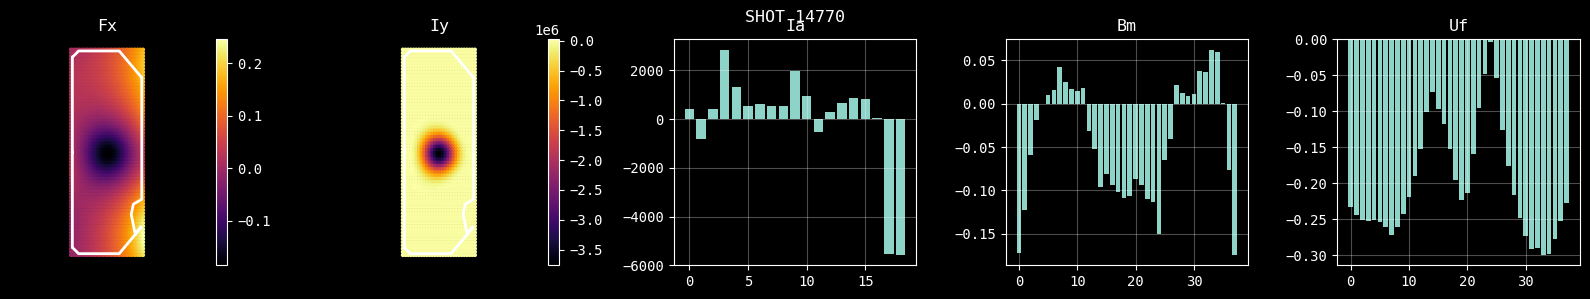

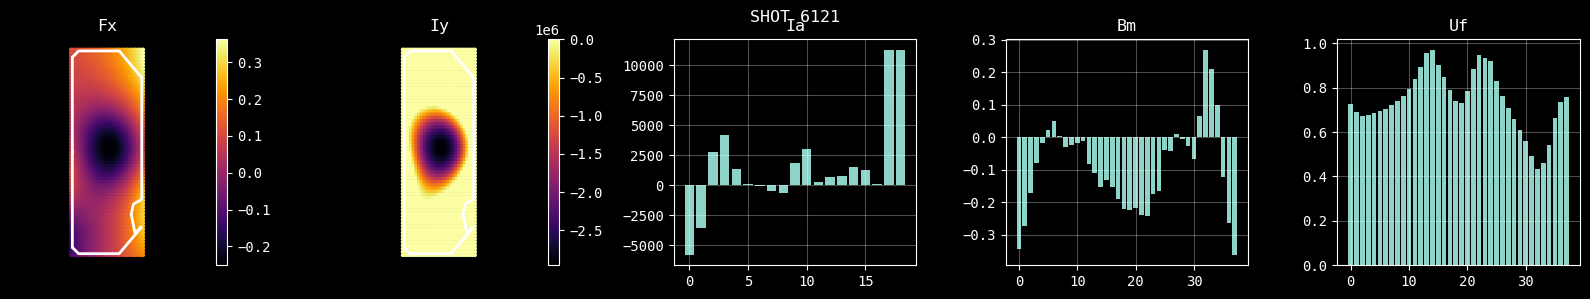

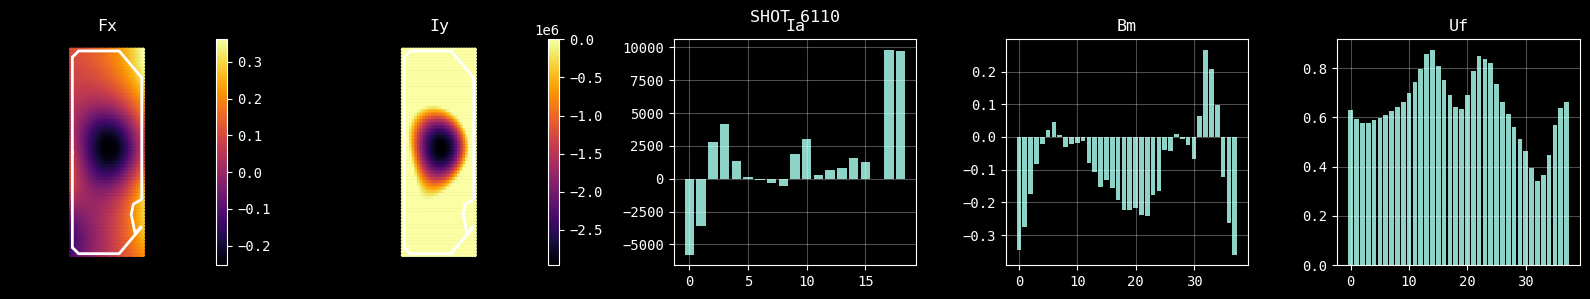

In [6]:
# plot some examples
n_plot = 3 if HAS_SCREEN else 15
rand_idxs = np.random.randint(0, N_OR, n_plot)
for i, ri in enumerate(rand_idxs):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    # plt.contourf(RRD, ZZD, Y[ri], levels=20)
    plt.scatter(RRD, ZZD, c=Y[ri], s=4)
    plt.plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
    plt.axis('equal'), plt.axis('off')
    plt.title('Fx')
    plt.colorbar()
    plt.subplot(1, 5, 2)
    # plt.contourf(RRD, ZZD, RHS[ri], levels=20)
    plt.scatter(RRD, ZZD, c=RHS[ri], s=4)
    plt.plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
    plt.axis('equal'), plt.axis('off')
    plt.title('Iy')
    plt.colorbar()
    plt.subplot(1, 5, 3)
    plt.bar(np.arange(Ia.shape[1]), Ia[ri])
    plt.title('Ia')
    plt.subplot(1, 5, 4)
    plt.bar(np.arange(Bm.shape[1]), Bm[ri])
    plt.title('Bm')
    plt.subplot(1, 5, 5)
    plt.bar(np.arange(Uf.shape[1]), Uf[ri])
    plt.title('Uf')
    plt.tight_layout()
    plt.suptitle(f'SHOT {ri}')
    plt.show() if HAS_SCREEN else plt.savefig(f'{DATA_DIR}/original_{i}.png')
    plt.close()

(65, 28) (65, 28) (24, 24) (24, 24)


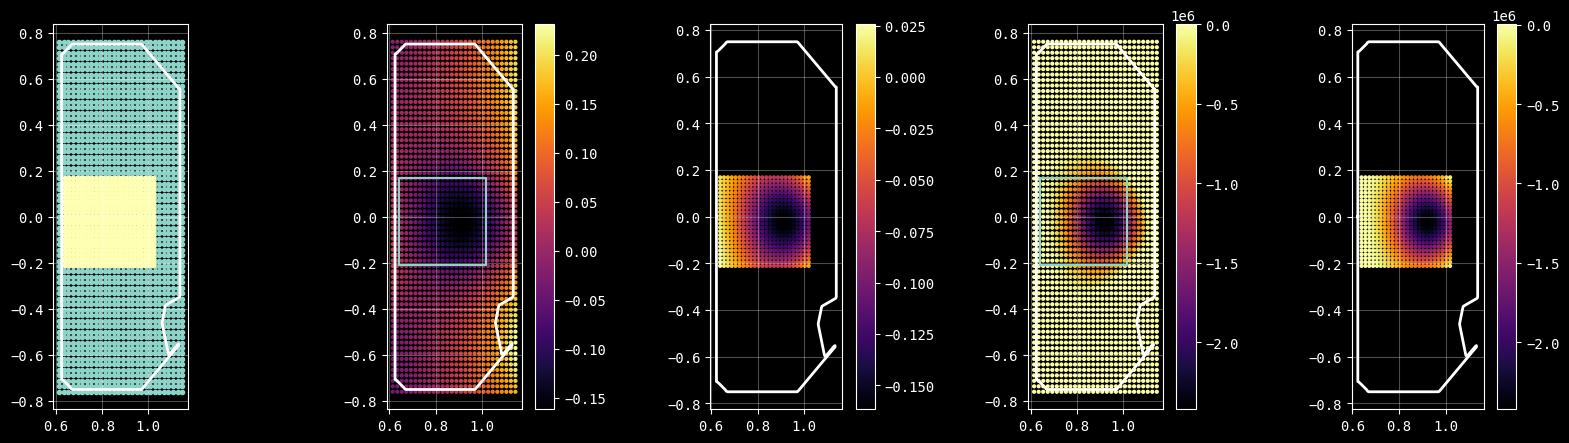

In [18]:
# test interpolation
idx = np.random.randint(0, N_OR)
f, rhs = Y[idx,:,:], RHS[idx,:,:]
rrg, zzg = sample_random_subgrid(RRD,ZZD, NGZ, NGR)
print(f.shape, rhs.shape, rrg.shape, zzg.shape)
box = grid2box(rrg, zzg)
f_grid = interp_fun(Fx[idx,:,:], RRD, ZZD, rrg, zzg)
rhs_grid = interp_fun(rhs, RRD, ZZD, rrg, zzg)

fig,ax = plt.subplots(1,5, figsize=(20,5))
ax[0].scatter(RRD, ZZD, marker='.')
ax[0].scatter(rrg, zzg, marker='.')
ax[0].plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
ax[0].set_aspect('equal')

# im1 = ax[1].contourf(RRD, ZZD, f, 20)
im1 = ax[1].scatter(RRD, ZZD, c=f.flatten(), s=4)
ax[1].plot(box[:,0],box[:,1])
ax[1].plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
ax[1].set_aspect('equal')

# im2 = ax[2].contourf(rrg, zzg, f_grid, 20)
im2 = ax[2].scatter(rrg, zzg, c=f_grid.flatten(), s=4)
ax[2].plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
ax[2].set_aspect('equal')

# im3 = ax[3].contourf(RRD, ZZD, rhs, 20)
im3 = ax[3].scatter(RRD, ZZD, c=rhs.flatten(), s=4)
ax[3].set_aspect('equal')
ax[3].plot(box[:,0],box[:,1])
ax[3].plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)

# im4 = ax[4].contourf(rrg, zzg, rhs_grid, 20)
im4 = ax[4].scatter(rrg, zzg, c=rhs_grid.flatten(), s=4)
ax[4].plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
ax[4].set_aspect('equal')

plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
plt.colorbar(im3,ax=ax[3])
plt.colorbar(im4,ax=ax[4])

plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, 'interpolation_example.png'))
plt.close()

In [8]:
# dataset splitting (N_TOP = original dataset size)
NT = int(N_SAMPLES*TRAIN_EVAL_SPLIT)    # training
NE = N_SAMPLES - NT                     # evaluation
NTM, NEM = NT*SM, NE*SM # training and evaluation with multiple grids
print(f"Train -> NT:{NT} NTM:{NTM}")
print(f"Eval  -> NE:{NE} NEM:{NEM}")
orig_idxs = np.random.permutation(N_OR)
orig_idxs_train = orig_idxs[:int(N_OR*TRAIN_EVAL_SPLIT)] # original indices for training
orig_idxs_eval = orig_idxs[int(N_OR*TRAIN_EVAL_SPLIT):] # original indices for evaluation
# splitting the idxs
assert len(orig_idxs_train) > NT, f"Training set is too small, {len(orig_idxs_train)} < {NT}"
idxs_t = np.random.choice(orig_idxs_train, NT, replace=False) # can overlap with idxs_tf
assert len(orig_idxs_eval) > NE, f"Evaluation set is too small, {len(orig_idxs_eval)} < {NE}"
idxs_e = np.random.choice(orig_idxs_eval, NE, replace=False) # can overlap with idxs_ef

Train -> NT:640 NTM:9600
Eval  -> NE:160 NEM:2400


In [ ]:
# create arrays to store the dataset
print(f"Preallocating arrays for the dataset...", flush=True)

x_t =   np.zeros((NTM, NIN), dtype=DTYPE)
y_t =   np.zeros((NTM, NGZ, NGR), dtype=DTYPE)
r_t =   np.zeros((NTM, NGR), dtype=DTYPE)
z_t =   np.zeros((NTM, NGZ), dtype=DTYPE)
rhs_t = np.zeros((NTM, NGZ, NGR), dtype=DTYPE)

x_e =   np.zeros((NEM, NIN), dtype=DTYPE)
y_e =   np.zeros((NEM, NGZ, NGR), dtype=DTYPE)
r_e =   np.zeros((NEM, NGR), dtype=DTYPE)
z_e =   np.zeros((NEM, NGZ), dtype=DTYPE)
rhs_e = np.zeros((NEM, NGZ, NGR), dtype=DTYPE)

# estimate RAM usage
ram_usage = sum(arr.nbytes for arr in [x_t, y_t, r_t, z_t, rhs_t, x_e, y_e, r_e, z_e, rhs_e]) / 1024**3
print(f"Estimated RAM usage: {ram_usage:.2f} GB\nFilling arrays...", flush=True)

## fill the arrays
print_every = 2000
start_time = time()
for i, idx in enumerate(idxs_t):
    rrs, zzs = np.zeros((SM,NGZ,NGR), dtype=DTYPE), np.zeros((SM,NGZ,NGR), dtype=DTYPE)
    for j in range(SM): rrs[j], zzs[j] = sample_random_subgrid(RRD,ZZD,NGZ,NGR)
    si, ei = i*SM, (i+1)*SM # start and end idxs
    x_t[si:ei] = X[idx]
    y_t[si:ei] = interp_fun(Y[idx], RRD, ZZD, rrs, zzs)
    rhs_t[si:ei] = interp_fun(RHS[idx], RRD, ZZD, rrs, zzs)
    r_t[si:ei], z_t[si:ei] = rrs[:,0,:], zzs[:,:,0] # save only the first raw/col
    if (i+1) % print_every == 0: print(f"Train: {(i+1)*SM}/{NTM}, eta: {((time()-start_time)/(i+1)*(NT-i-1))/60:.1f} min", flush=True)

start_time = time()
for i, idx in enumerate(idxs_e):
    rrs, zzs = np.zeros((SM,NGZ,NGR), dtype=DTYPE), np.zeros((SM,NGZ,NGR), dtype=DTYPE)
    for j in range(SM): rrs[j], zzs[j] = sample_random_subgrid(RRD,ZZD,NGZ,NGR)
    si, ei = i*SM, (i+1)*SM # start and end idxs
    x_e[si:ei] = X[idx]
    y_e[si:ei] = interp_fun(Y[idx], RRD, ZZD, rrs, zzs)
    rhs_e[si:ei] = interp_fun(RHS[idx], RRD, ZZD, rrs, zzs)
    r_e[si:ei], z_e[si:ei] = rrs[:,0,:], zzs[:,:,0] # save only the first raw/col
    if (i+1) % print_every == 0: print(f"Eval: {(i+1)*SM}/{NEM}, eta: {((time()-start_time)/(i+1)*(NE-i-1))/60:.1f} min", flush=True)

print(f"x_t: {x_t.shape}, y_t: {y_t.shape}, r_t: {r_t.shape}, z_t: {z_t.shape}, rhs_t: {rhs_t.shape}")
print(f"x_e: {x_e.shape}, y_e: {y_e.shape}, r_e: {r_e.shape}, z_e: {z_e.shape}, rhs_e: {rhs_e.shape}")

Preallocating arrays for the dataset...
Estimated RAM usage: 0.06 GB
Filling arrays...
x_t: (9600, 95), y_t: (9600, 24, 24), r_t: (9600, 24), z_t: (9600, 24), rhs_t: (9600, 24, 24)
x_e: (2400, 95), y_e: (2400, 24, 24), r_e: (2400, 24), z_e: (2400, 24), rhs_e: (2400, 24, 24)


In [10]:
# calculate kernels for Grad-Shafranov equation # NOTE: not needed actually, but here to be tested
# so we don't have to do it during training
laplace_ker_t = np.zeros((len(x_t[0]), 3, 3), dtype=DTYPE)
laplace_ker_e = np.zeros((len(x_e[0]), 3, 3), dtype=DTYPE)
df_dr_ker_t = np.zeros((len(x_t[0]), 3, 3), dtype=DTYPE)
df_dr_ker_e = np.zeros((len(x_e[0]), 3, 3), dtype=DTYPE)
# hrs_t, hzs_t = r_t[:,1,2]-r_t[:,1,1], z_t[:,2,1]-z_t[:,1,1]
# hrs_e, hzs_e = r_e[:,1,2]-r_e[:,1,1], z_e[:,2,1]-z_e[:,1,1]
hrs_e, hzs_e = r_e[:,2]-r_e[:,1], z_e[:,2]-z_e[:,1]
hrs_t, hzs_t = r_t[:,2]-r_t[:,1], z_t[:,2]-z_t[:,1]
for i in range(len(x_t[0])):
    try:
        laplace_ker_t[i,:,:], df_dr_ker_t[i,:,:] = calc_laplace_df_dr_ker(hrs_t[i], hzs_t[i])
    except Exception as e:
        print(f"Error calculating laplace_ker_t for index {i}: {e}")
        plt.figure()
        plt.scatter(r_t[i], z_t[i], marker='.')
        plt.title(f"r_t[{i}]")
        plt.axis('equal')
        plt.show() if HAS_SCREEN else plt.savefig(f'{DATA_DIR}/rr_train_{i}.png')
        plt.close()
        break

for i in range(len(x_e[0])):
    laplace_ker_e[i,:,:], df_dr_ker_e[i,:,:] = calc_laplace_df_dr_ker(hrs_e[i], hzs_e[i])

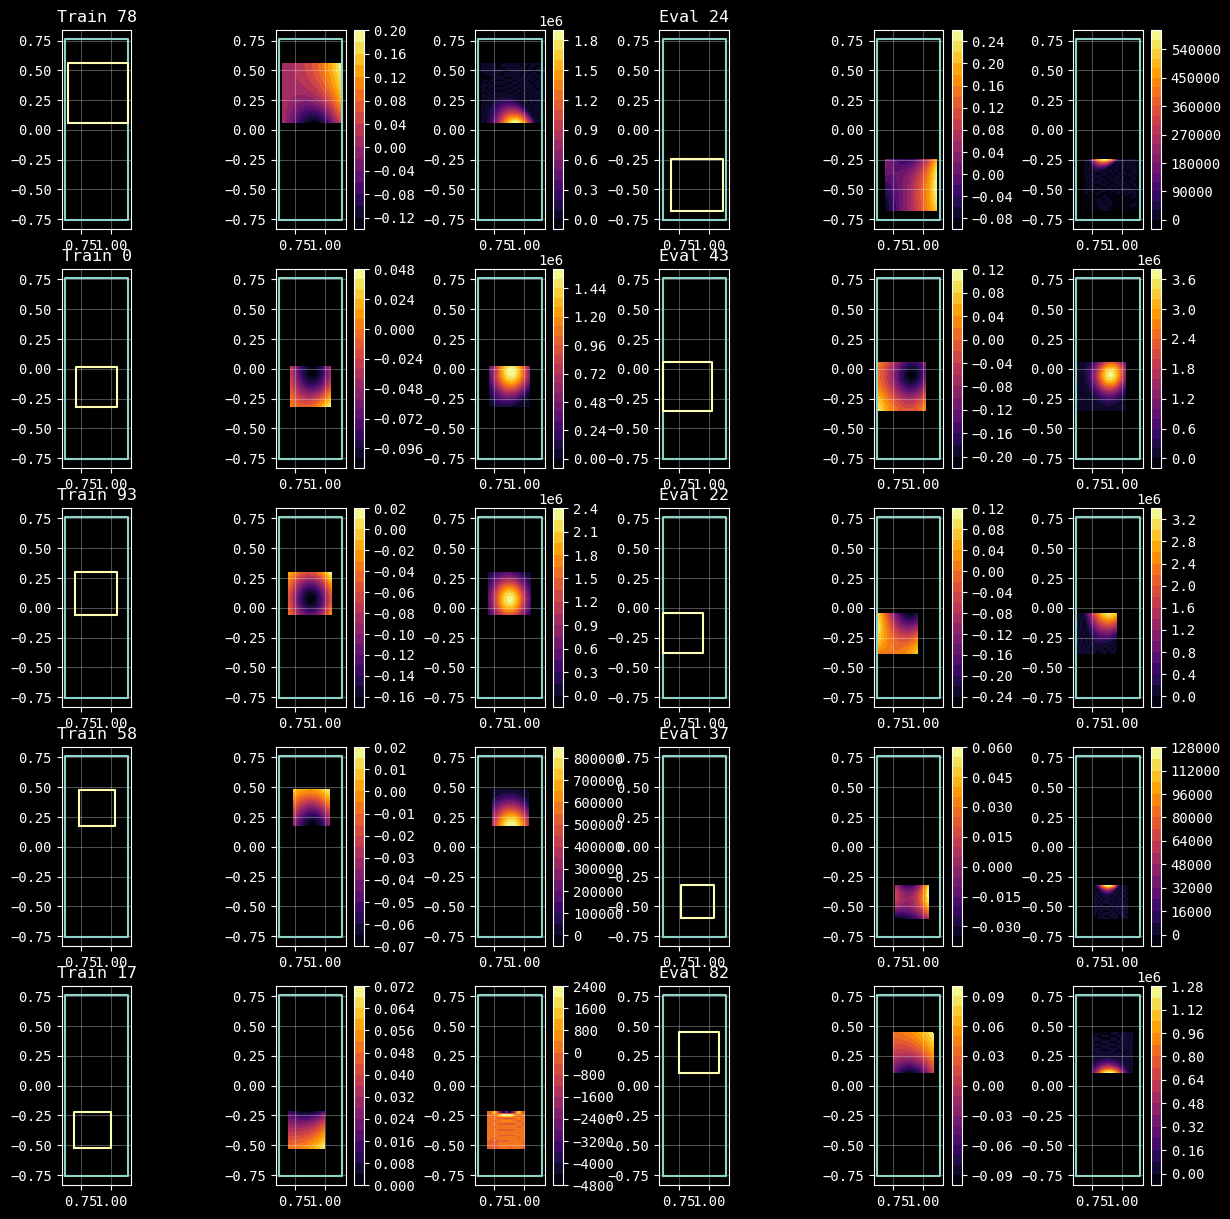

In [11]:
# check the dataset
rows = 5
idxs_train = np.random.randint(0, len(x_t[0]), rows)
idxs_eval = np.random.randint(0, len(x_e[0]), rows)
fig,ax = plt.subplots(rows,6, figsize=(15,3*rows))
box0 = grid2box(RRD, ZZD)
for i, (it, ie)  in enumerate(zip(idxs_train, idxs_eval)):
    # training
    boxi = grid2box(r_t[it], z_t[it])
    ax[i,0].plot(box0[:,0], box0[:,1])
    ax[i,0].plot(boxi[:,0], boxi[:,1])
    ax[i,0].set_aspect('equal')
    ax[i,0].set_title(f"Train {it}")
    a1 = ax[i,1].contourf(r_t[it], z_t[it], y_t[it], 20)
    ax[i,1].plot(box0[:,0], box0[:,1])
    ax[i,1].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,1])
    a2 = ax[i,2].contourf(r_t[it], z_t[it] ,-rhs_t[it], 20)
    ax[i,2].plot(box0[:,0], box0[:,1])
    ax[i,2].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,2])
    # evaluation
    boxi = grid2box(r_e[ie], z_e[ie])
    ax[i,3].plot(box0[:,0], box0[:,1])
    ax[i,3].plot(boxi[:,0], boxi[:,1])
    ax[i,3].set_aspect('equal')
    ax[i,3].set_title(f"Eval {ie}")
    a1 = ax[i,4].contourf(r_e[ie], z_e[ie], y_e[ie], 20)
    ax[i,4].plot(box0[:,0], box0[:,1])
    ax[i,4].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,4])
    a2 = ax[i,5].contourf(r_e[ie], z_e[ie] ,-rhs_e[ie], 20)
    ax[i,5].plot(box0[:,0], box0[:,1])
    ax[i,5].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,5])
plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, 'dataset_check.png'))
plt.close()

psi: torch.Size([7, 1, 24, 24]), r: torch.Size([7, 24]), z: torch.Size([7, 24])
gsos: torch.Size([7, 1, 24, 24])


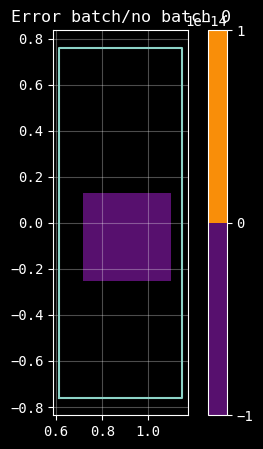

max error batch/no batch: 0.0


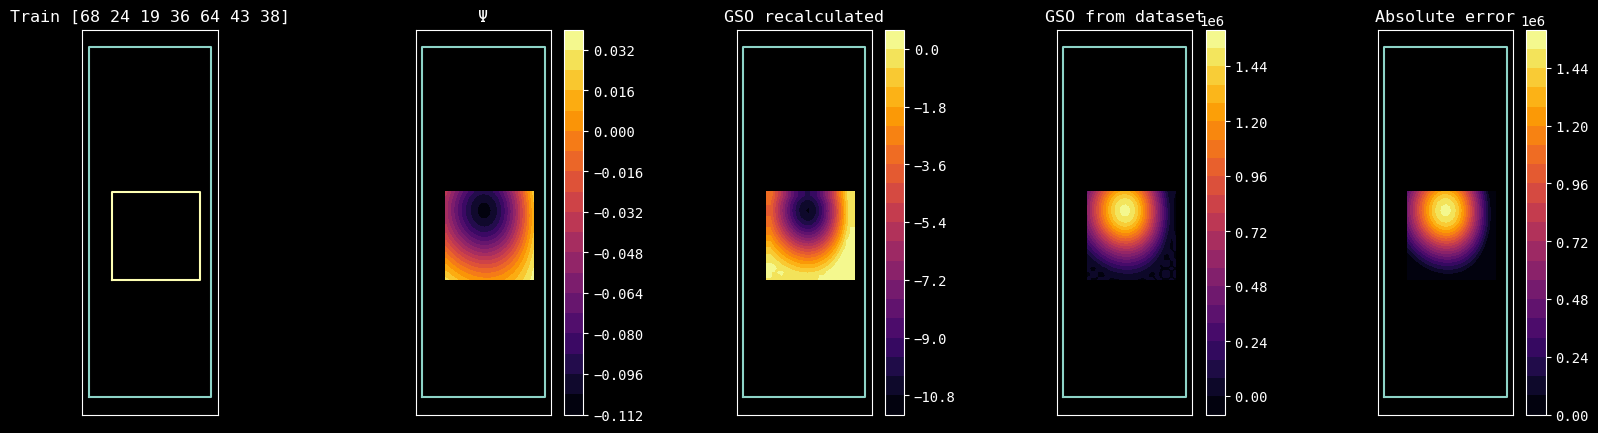

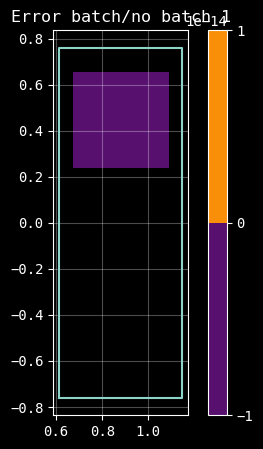

max error batch/no batch: 0.0


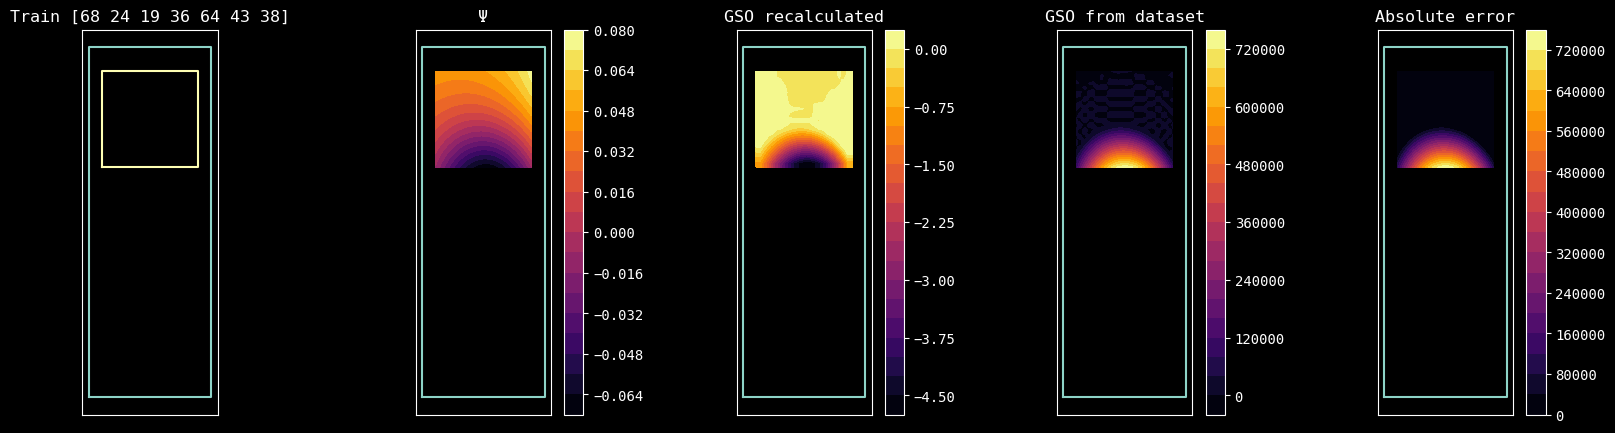

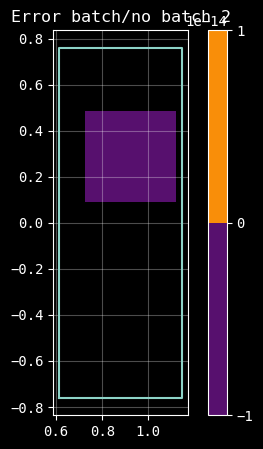

max error batch/no batch: 0.0


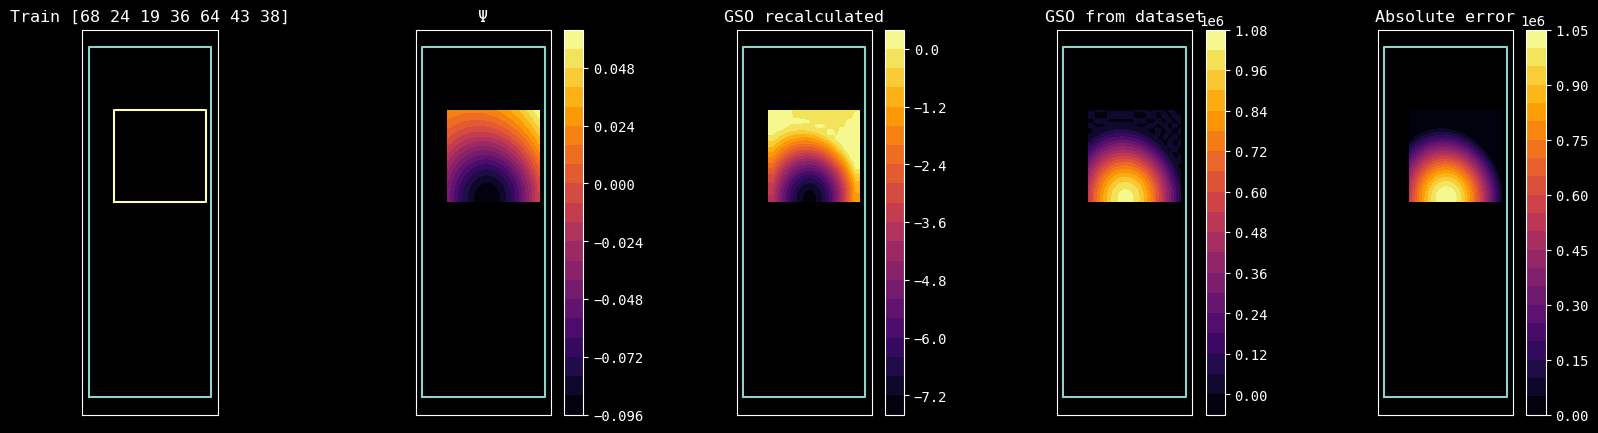

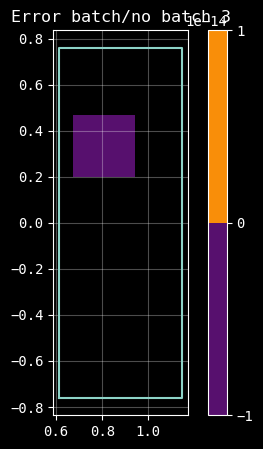

max error batch/no batch: 0.0


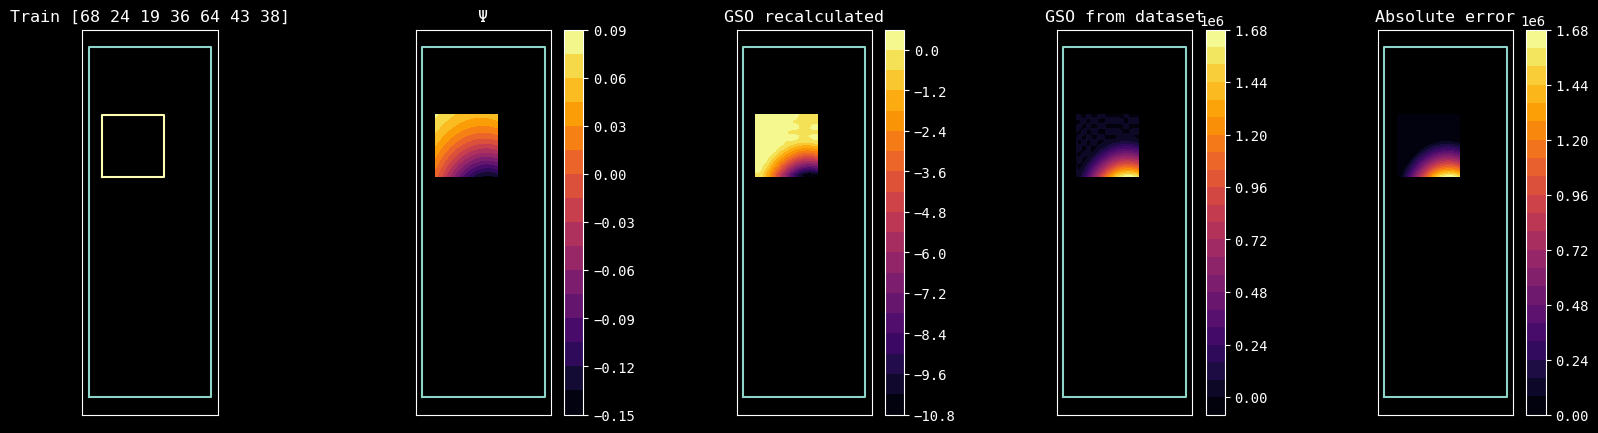

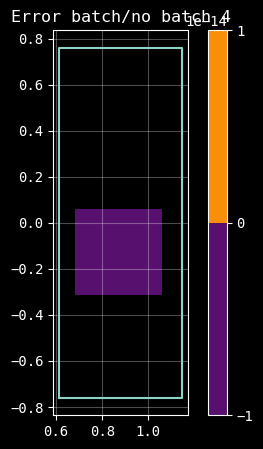

max error batch/no batch: 0.0


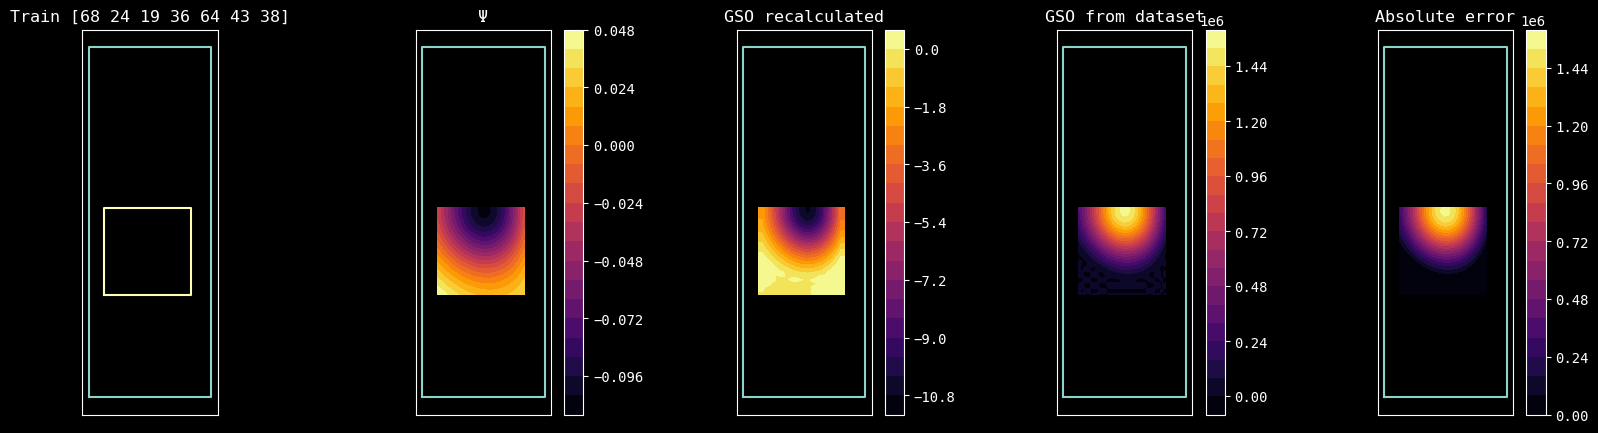

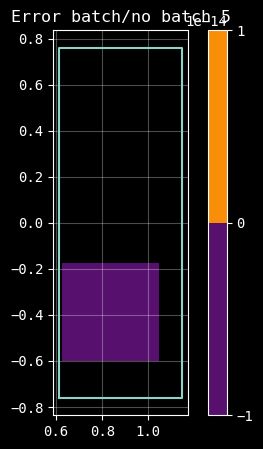

max error batch/no batch: 0.0


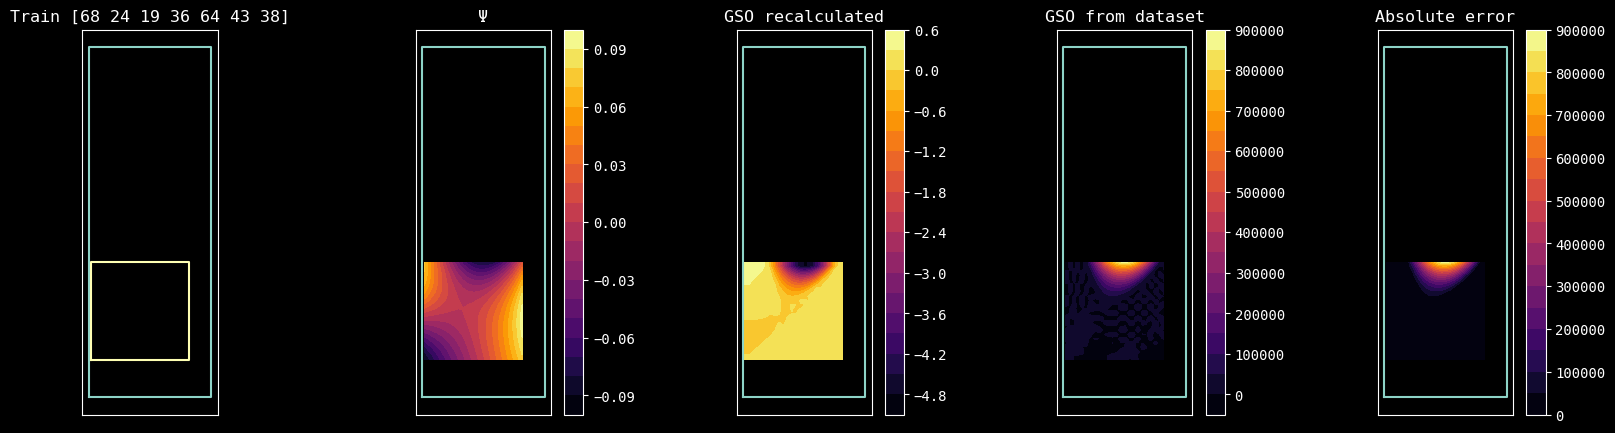

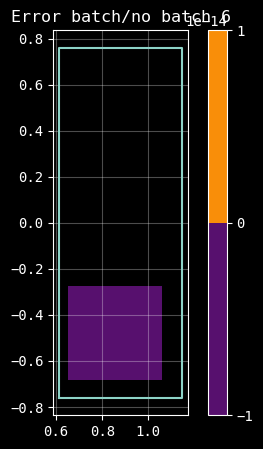

max error batch/no batch: 0.0


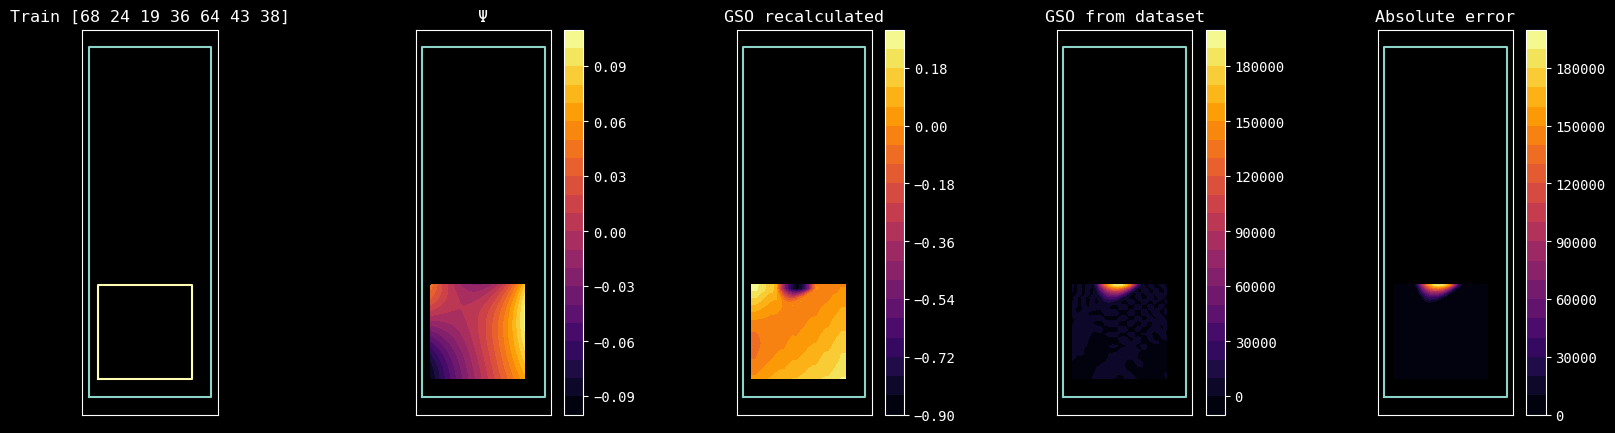

In [12]:
from utils import calc_gso, calc_gso_batch
import torch
n_plots = 7
idxs = np.random.randint(0, len(x_t[0]), n_plots)
psis, rhss = y_t[idxs], rhs_t[idxs]
rs, zs = r_t[idxs], z_t[idxs]
big_box = grid2box(RRD, ZZD)
#batched version
psist = torch.tensor(psis, dtype=torch.float32).view(n_plots, 1, NGZ, NGR)
rst = torch.tensor(rs, dtype=torch.float32).view(n_plots, NGR)
zst = torch.tensor(zs, dtype=torch.float32).view(n_plots, NGZ)
print(f'psi: {psist.shape}, r: {rst.shape}, z: {zst.shape}')
gsos = calc_gso_batch(psist, rst, zst)
print(f'gsos: {gsos.shape}')
gsos = gsos.view(n_plots, NGZ, NGR).numpy()
# single version
for i in range(n_plots):
    psi, r, z, rhs = psis[i], rs[i], zs[i], rhss[i]
    box = grid2box(r, z)
    gso = calc_gso(psi, r, z) # calculate the Grad-Shafranov operator
    gso2 = gsos[i]
    #plot error gso vs gso2
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    rr, zz = np.meshgrid(r, z)
    im = ax.contourf(rr, zz, np.abs(gso-gso2), 20)
    ax.plot(big_box[:,0], big_box[:,1])
    ax.set_aspect('equal')
    ax.set_title(f"Error batch/no batch {i}")
    plt.colorbar(im, ax=ax)
    plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, f'gso_error_{i}.png'))
    plt.close()
    # NOTE: the error between the batched and non-batched version can be non-zero due to different
    # implementations in gpu
    print(f"max error batch/no batch: {np.abs(gso-gso2).max()}")
    # assert np.allclose(gso, gso2, rtol=1e-2), f"Error in the calculation of the Grad-Shafranov operator: \ngso:\n{gso}, \ngso2:\n{gso2}"
    # psi, gso, rhs = psi[1:-1,1:-1], gso[1:-1,1:-1], rhs[1:-1,1:-1]
    # rr, zz = rr[1:-1,1:-1], zz[1:-1,1:-1] 
    fig,ax = plt.subplots(1,5, figsize=(20,5))
    ax[0].plot(big_box[:,0], big_box[:,1])
    ax[0].plot(box[:,0], box[:,1])
    ax[0].set_aspect('equal')
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[0].set_title(f"Train {idxs}")
    im1 = ax[1].contourf(rr, zz, psi, 20)
    ax[1].plot(big_box[:,0], big_box[:,1])
    ax[1].set_aspect('equal')
    ax[1].set_xticks([]), ax[1].set_yticks([])
    ax[1].set_title("Ψ")
    im2 = ax[2].contourf(rr, zz, -gso, 20)
    ax[2].plot(big_box[:,0], big_box[:,1])
    ax[2].set_aspect('equal')
    ax[2].set_xticks([]), ax[2].set_yticks([])
    ax[2].set_title("GSO recalculated")
    im3 = ax[3].contourf(rr, zz, -rhs, 20)
    ax[3].plot(big_box[:,0], big_box[:,1])
    ax[3].set_aspect('equal')
    ax[3].set_xticks([]), ax[3].set_yticks([])
    ax[3].set_title("GSO from dataset")
    im4 = ax[4].contourf(rr, zz, np.abs(gso-rhs), 20)
    ax[4].plot(big_box[:,0], big_box[:,1])
    ax[4].set_aspect('equal')
    ax[4].set_xticks([]), ax[4].set_yticks([])
    ax[4].set_title("Absolute error")
    plt.colorbar(im1,ax=ax[1])
    plt.colorbar(im2,ax=ax[2])
    plt.colorbar(im3,ax=ax[3])
    plt.colorbar(im4,ax=ax[4])
    plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, f'gso_check_{i}.png'))
    plt.close()

In [13]:
assert y_t.shape[1:] == (NGR, NGZ), f"x_t shape mismatch: {x_t[0].shape[1:]} != ({NGR}, {NGZ})"
assert y_e.shape[1:] == (NGR, NGZ), f"x_e shape mismatch: {x_e[0].shape[1:]} != ({NGR}, {NGZ})"

In [14]:
# load dataset and normalize inputs
x_t_mean, x_t_std = np.vstack([np.mean(x_t, axis=0), np.std(x_t, axis=0)])

# normalize (NOTE: both with the same mean and std)
x_t = (x_t - x_t_mean) / x_t_std
x_e = (x_e - x_t_mean) / x_t_std

print(f'x_t_mean: {x_t_mean.shape}, x_t_std: {x_t_std.shape}')

x_t_mean: (95,), x_t_std: (95,)


In [15]:
# save dataset as numpy compressed
train_ds_path = join(DATA_DIR, f'train_ds_{N_SAMPLES}_{TRAIN_EVAL_SPLIT*100:.0f}_{SM:.0f}.npz')
eval_ds_path = join(DATA_DIR, f'eval_ds_{N_SAMPLES}_{TRAIN_EVAL_SPLIT*100:.0f}_{SM:.0f}.npz')
np.savez_compressed(train_ds_path, X=x_t, Y=y_t, r=r_t, z=z_t)
np.savez_compressed(eval_ds_path, X=x_e, Y=y_e, r=r_e, z=z_e)
print(f"Train dataset saved to {train_ds_path}")
print(f"Eval dataset saved to {eval_ds_path}")

Train dataset saved to dss/ds/train_ds_800_80_15.npz
Eval dataset saved to dss/ds/eval_ds_800_80_15.npz


In [16]:
# copy so that train.py can load it
os.system(f'cp {train_ds_path} dss/train_ds.npz')
os.system(f'cp {eval_ds_path} dss/eval_ds.npz')

0

train_ds: KeysView(NpzFile 'dss/ds/train_ds_800_80_15.npz' with keys: X, Y, r, z)
eval_ds: KeysView(NpzFile 'dss/ds/eval_ds_800_80_15.npz' with keys: X, Y, r, z)
rs shape: (9600, 24), zs shape: (9600, 24), xs shape: (9600, 95), ys shape: (9600, 24, 24)


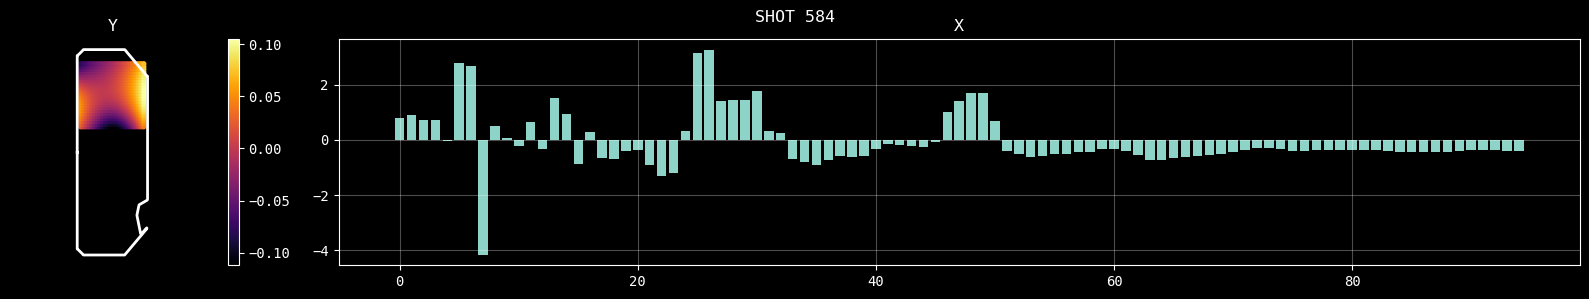

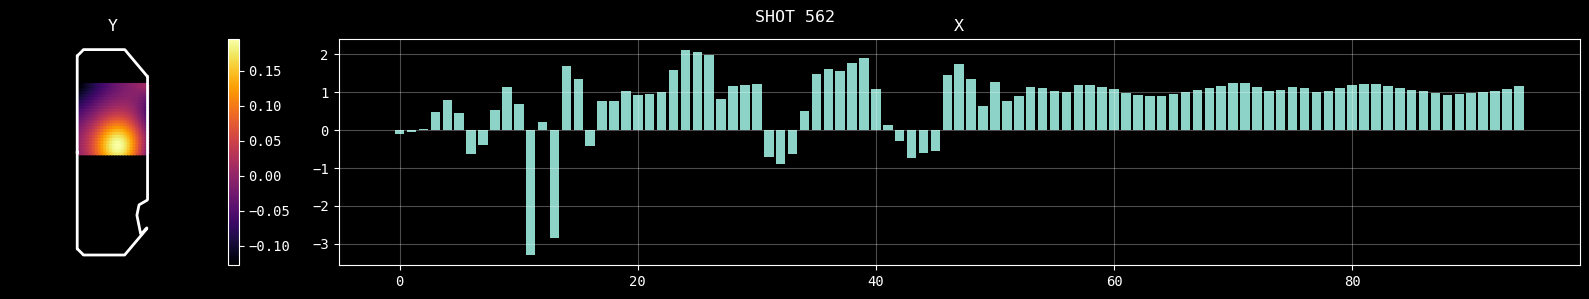

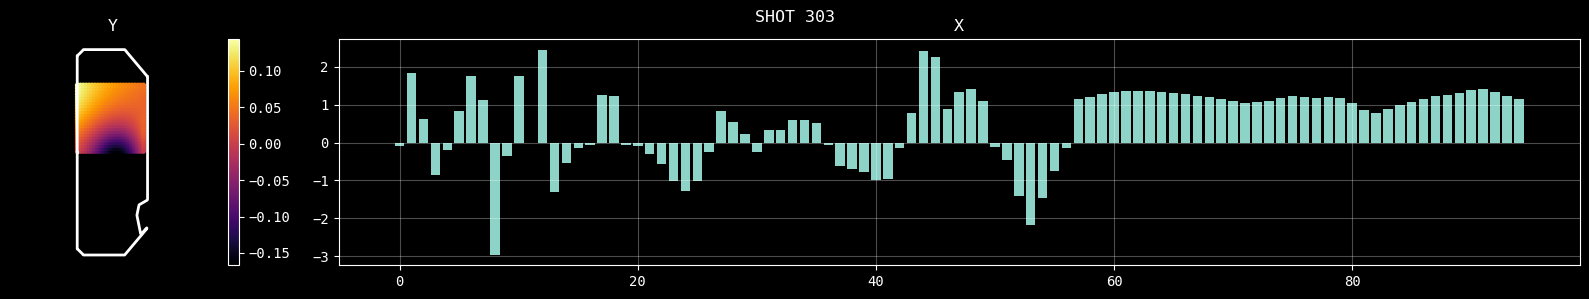

In [17]:
# plot some examples
# tds, eds = loadmat(train_ds_path), loadmat(eval_ds_path)
tds, eds = np.load(train_ds_path), np.load(eval_ds_path)
print(f'train_ds: {tds.keys()}')
print(f'eval_ds: {eds.keys()}')
# plot some examples
rs, zs, xs, ys = tds['r'], tds['z'], tds['X'], tds['Y']
print(f'rs shape: {rs.shape}, zs shape: {zs.shape}, xs shape: {xs.shape}, ys shape: {ys.shape}')

n_plot = 3 if HAS_SCREEN else 100
rand_idxs = np.random.randint(0, NT, n_plot)
for i, ri in enumerate(rand_idxs):
    r, z, x, y = rs[ri], zs[ri], xs[ri], ys[ri]
    rr, zz = np.meshgrid(r, z)
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    # plt.contourf(rr, zz, y, levels=20)
    plt.scatter(rr, zz, c=y.flatten(), marker='.')
    plt.plot(VESS[:,0], VESS[:,1], color="white", linewidth=2)
    plt.axis('equal'), plt.axis('off')
    plt.title('Y')
    plt.colorbar()
    plt.subplot(1, 5, (2,5))
    plt.bar(np.arange(x.shape[0]), x)
    plt.title('X')
    plt.tight_layout()
    plt.suptitle(f'SHOT {ri}')
    plt.show() if HAS_SCREEN else plt.savefig(f'{DATA_DIR}/ds_{i}.png')
    plt.close()